# Data Augmentation of Vibration Signals Dataset with use of GANs

Author: Marcin Stopyra

MLMech course project

University of Stuttgart 2022

Project based on dataset from paper:  


[Mey, Oliver, Willi Neudeck, Andre Schneider, and Olaf Enge-Rosenblatt. *“Machine Learning-Based Unbalance Detection of a Rotating Shaft Using Vibration Data.”* In 2020 25th IEEE International Conference on Emerging Technologies and Factory Automation (ETFA). IEEE. 2020](https://arxiv.org/pdf/2005.12742.pdf)

[(Dataset available on Kaggle)](https://www.kaggle.com/datasets/jishnukoliyadan/vibration-analysis-on-rotating-shaft)

## libraries and loading dataset from Kaggle

In [ ]:
!pip install scikeras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential
import tensorflow as tf
import json
from itertools import product
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.activations import relu, selu
from keras.layers import LeakyReLU
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import PredefinedSplit
import ast


from google.colab import drive
import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mounting Google Drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/kaggle_API"

# Reading kaggle key from google drive
!mkdir ~/.kaggle
!cp -r '/content/drive/My Drive/kaggle_API/kaggle.json' kaggle.json
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Reading dataset
!mkdir data
!kaggle datasets download jishnukoliyadan/vibration-analysis-on-rotating-shaft -p /content/data/ --unzip

Mounted at /content/drive
kaggle.json
100% 2.62G/2.62G [01:09<00:00, 36.4MB/s]
100% 2.62G/2.62G [01:09<00:00, 40.6MB/s]


## Reading data

**Datasets** are described with:
1. digit - indicating the level of unbalance (0-no unbalance, 4-highest imbalance)
2. letter D or E - D means that the dataset is a **development** dataset for training, E means **evaluation** dataset

In this project a pair of subsets will be used:
- balanced signals dataset 0
- imbalanced signals dataset 1

In [ ]:
# Training set
# Balanced dataset
df_balanced_d = pd.read_csv("./data/0D.csv")
df_balanced_d = df_balanced_d.dropna()

# Unbalanced dataset (unbalance level 2)
df_unbalanced_d = pd.read_csv("./data/2D.csv")
df_unbalanced_d = df_unbalanced_d.dropna()

# Test set
df_balanced_e = pd.read_csv("./data/0E.csv")
df_balanced_e = df_balanced_e.dropna()

# Unbalanced dataset (unbalance level 2)
df_unbalanced_e = pd.read_csv("./data/2E.csv")
df_unbalanced_e = df_unbalanced_e.dropna()

## Dataset exploration and preprocessing

### Exploration of tabular data and cleaning samples with outlying RPMs

In [ ]:
df_balanced_d.sample(10)

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
22303909,7.55,1768.24250,-0.003545,0.000355,0.004559
5980609,5.60,1360.14330,-0.000863,-0.000648,0.001835
26384886,10.00,2376.16720,-0.000449,-0.012145,0.009726
13955905,2.45,713.76955,0.000527,0.000590,0.003002
10307127,8.25,1909.29280,-0.007755,0.004883,0.004143
5411835,5.25,1329.63260,0.001241,0.001780,0.001851
24846631,9.10,2153.74140,-0.014237,-0.003581,0.009961
19802247,6.00,1489.17560,0.003256,-0.001423,0.004587
656388,2.35,714.75375,0.000473,0.001014,0.002682
15190840,3.20,897.95160,0.000850,0.000497,0.003365


In [ ]:
df_balanced_d.describe()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.642330e+07,2.642330e+07,2.642330e+07,2.642330e+07,2.642330e+07
mean,5.992249e+00,-3.572305e+04,1.981370e-03,2.713846e-03,4.202591e-03
std,2.329660e+00,2.987905e+06,6.284235e-02,8.682009e-02,6.599321e-02
min,0.000000e+00,-2.400000e+08,-1.067495e-01,-2.067244e-01,-3.653050e-02
25%,4.000000e+00,1.052549e+03,-1.059771e-03,-1.188517e-03,1.739263e-03
50%,6.000000e+00,1.483102e+03,6.246567e-04,6.520748e-04,2.712011e-03
75%,8.000000e+00,1.906805e+03,2.528429e-03,2.536774e-03,3.825426e-03
max,1.000000e+01,2.376685e+03,7.805610e+00,8.780816e+00,7.790682e+00


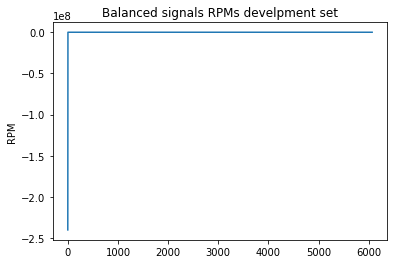

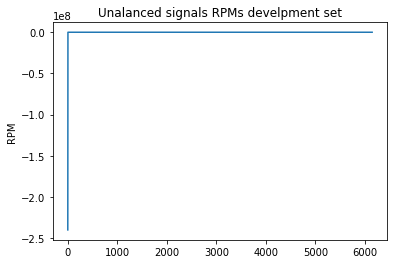

In [ ]:
plt.figure()
plt.plot(np.sort(df_balanced_d.Measured_RPM.unique()))
plt.title("Balanced signals RPMs develpment set")
plt.ylabel("RPM")
plt.show()

plt.figure()
plt.plot(np.sort(df_unbalanced_d.Measured_RPM.unique()))
plt.title("Unalanced signals RPMs develpment set")
plt.ylabel("RPM")
plt.show()

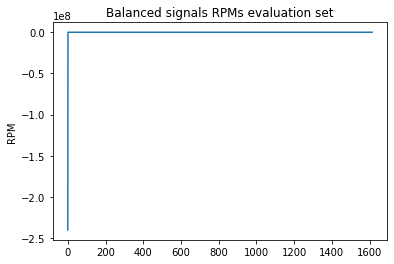

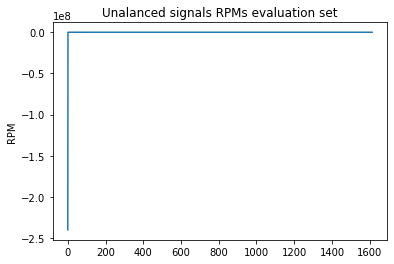

In [ ]:
plt.figure()
plt.plot(np.sort(df_balanced_e.Measured_RPM.unique()))
plt.title("Balanced signals RPMs evaluation set")
plt.ylabel("RPM")
plt.show()

plt.figure()
plt.plot(np.sort(df_unbalanced_e.Measured_RPM.unique()))
plt.title("Unalanced signals RPMs evaluation set")
plt.ylabel("RPM")
plt.show()

As we can see there is at least 1 sample at beginning with outlying really big negative value of RPM. We will try to recognise it by visualising signal RPMs without first sample/samples

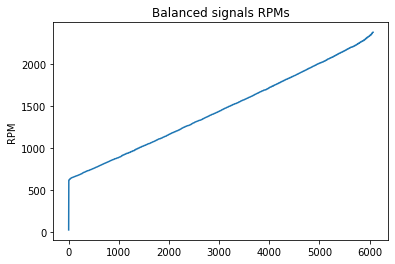

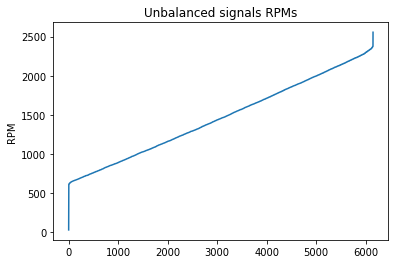

In [ ]:
plt.figure()
plt.plot(np.sort(df_balanced_d.Measured_RPM.unique())[1:])
plt.title("Balanced signals RPMs")
plt.ylabel("RPM")
plt.show()

plt.figure()
plt.plot(np.sort(df_unbalanced_d.Measured_RPM.unique())[1:])
plt.title("Unbalanced signals RPMs")
plt.ylabel("RPM")
plt.show()

We see outlying RPMs also with really high RPMs on unbalanced signals (up to 4000rpms while on balanced shaft its approx 2250rpms). We will drop all the samples from unbalanced dataset with RPMs higher than maximum RPM in balanced dataset

In [ ]:
# Dropping all the samples with RPMs below 500 or higher than maximum RPM for balanced shaft
max_rpm = df_balanced_d.Measured_RPM.max()

df_balanced_d = df_balanced_d.drop(df_balanced_d[df_balanced_d.Measured_RPM < 500].index)

df_unbalanced_d = df_unbalanced_d.drop(df_unbalanced_d[df_unbalanced_d.Measured_RPM < 500].index)
df_unbalanced_d = df_unbalanced_d.drop(df_unbalanced_d[df_unbalanced_d.Measured_RPM > max_rpm].index)


max_rpm = df_balanced_d.Measured_RPM.max()

df_balanced_e = df_balanced_e.drop(df_balanced_e[df_balanced_e.Measured_RPM < 500].index)

df_unbalanced_e = df_unbalanced_e.drop(df_unbalanced_e[df_unbalanced_e.Measured_RPM < 500].index)
df_unbalanced_e = df_unbalanced_e.drop(df_unbalanced_e[df_unbalanced_e.Measured_RPM > max_rpm].index)

### extracting single signals and visualising them

In [ ]:
def extractSignal(df, approx_rpm='random', channel=1):
    """ Function takes a chosen/random signal from the dataset, by extracting all the points with the same RPM
    ---
    args:
        df:             chosen dataset
        approx_rpm:     approximately rpm we want
        channel:        channel of the signal we want to extract
    ---
    returns:
        signal:      a chosen signal
        signal_rpm:  rpm of the signal above
    """
    all_rpms = df.Measured_RPM.unique()

    if approx_rpm in ['random', 'Random', 'RANDOM']:
        signal_rpm = np.random.choice(df.Measured_RPM.unique())
    elif approx_rpm >= 0 and approx_rpm <= max(all_rpms):
        signal_rpm = findNearest(all_rpms, approx_rpm)
    else:
        return False, False
    signal = np.array(df[df.Measured_RPM == signal_rpm][f"Vibration_{channel}"])

    return signal, signal_rpm



def findNearest(arr, value):
    """ Function finds the element in the array with the nearest value to the one put by the user
    https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    ---
    args:
        arr:    given array
        value:  wanted value
    ---
    returns:
        arr[idx]:   element in the array with the nearest value to the one put by the user
    """
    arr = np.asarray(arr)
    idx = (np.abs(arr - value)).argmin()
    return arr[idx]

signal samples number: 4096


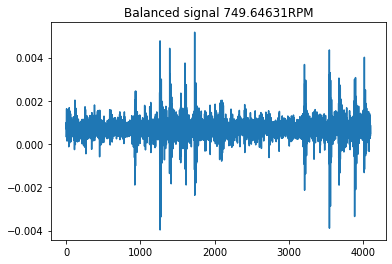

signal samples number: 4096


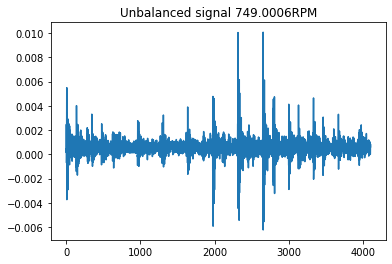

In [ ]:
# viualise random signals from balanced and unbalanced datasets with quite similar RPMs
## draw random RPM
random_rpm = np.random.randint(df_balanced_d.Measured_RPM.min(), df_balanced_d.Measured_RPM.max())

## balanced signal 
random_signal_balanced, random_signal_rpm_balanced = extractSignal(df_balanced_d, approx_rpm=random_rpm, channel=1)
print(f'signal samples number: {len(random_signal_balanced)}')
## display signal 
plt.figure()
plt.plot(random_signal_balanced)
plt.title(f"Balanced signal {random_signal_rpm_balanced}RPM")
plt.show()

## unbalanced signal
random_signal_unbalanced, random_signal_rpm_unbalanced = extractSignal(df_unbalanced_d, approx_rpm=random_rpm, channel=1)
print(f'signal samples number: {len(random_signal_unbalanced)}')
## display signal from the 1st channel
plt.figure()
plt.plot(random_signal_unbalanced)
plt.title(f"Unbalanced signal {random_signal_rpm_unbalanced}RPM")
plt.show()

### Creating numpy arrays with signals

In [ ]:
def createSignalArrays(dataset, channel=1, nb_of_samples_per_signal=4096):
    """ Function creates 2D numpy array in which each row is single signal for some given rpm
    ---
    args:
        dataset:                    pandas DataFrame with signals saved in original format
        channel:                    default=1, Channel of the signal user wants to extract
        nb_of_samples_per_signal:   default=4096, number of samples in given signal
    ---
    returns:
        signals:    2D numpy array in which each row is single signal for some given rpm
        rpms:       list of RPMs corresponding to signals in 'signals' array

    """
    rpms = np.sort(dataset.Measured_RPM.unique())
    nb_of_signals = len(rpms)
    signals = np.zeros((nb_of_signals, nb_of_samples_per_signal))
    

    for i, rpm in enumerate(rpms):
        signal, _ = extractSignal(dataset, approx_rpm=rpm, channel=channel)
        # skip all the shorter signals
        if len(signal) < nb_of_samples_per_signal:
            continue
        # trim all too log signals
        signals[i,:] = signal[:nb_of_samples_per_signal]
        
        

    return signals, rpms      

In [ ]:
# # extracting signals, takes a really long time

# signals_balanced_d, rpms_balanced_d = createSignalArrays(df_balanced_d)
# del df_balanced_d
# signals_unbalanced_d, rpms_unbalanced_d = createSignalArrays(df_unbalanced_d)
# del df_unbalanced_d

# signals_balanced_e, rpms_balanced_e = createSignalArrays(df_balanced_e)
# del df_balanced_e
# signals_unbalanced_e, rpms_unbalanced_e = createSignalArrays(df_unbalanced_e)
# del df_unbalanced_e

In [ ]:
# # save signal arrays
# np.savetxt("/content/drive/My Drive/data_extension_GANs/signals_balanced_d.csv", signals_balanced_d, delimiter=',')
# np.savetxt("/content/drive/My Drive/data_extension_GANs/signals_unbalanced_d.csv", signals_unbalanced_d, delimiter=',')

# np.savetxt("/content/drive/My Drive/data_extension_GANs/rpms_balanced_d.csv", rpms_balanced_d, delimiter=',')
# np.savetxt("/content/drive/My Drive/data_extension_GANs/rpms_unbalanced_d.csv", rpms_unbalanced_d, delimiter=',')

# np.savetxt("/content/drive/My Drive/data_extension_GANs/signals_balanced_e.csv", signals_balanced_e, delimiter=',')
# np.savetxt("/content/drive/My Drive/data_extension_GANs/signals_unbalanced_e.csv", signals_unbalanced_e, delimiter=',')

# np.savetxt("/content/drive/My Drive/data_extension_GANs/rpms_balanced_e.csv", rpms_balanced_e, delimiter=',')
# np.savetxt("/content/drive/My Drive/data_extension_GANs/rpms_unbalanced_e.csv", rpms_unbalanced_e, delimiter=',')

In [ ]:
# load signal arrays
signals_balanced_d = np.loadtxt("/content/drive/My Drive/data_extension_GANs/signals_balanced_d.csv", delimiter=',')
signals_unbalanced_d = np.loadtxt("/content/drive/My Drive/data_extension_GANs/signals_unbalanced_d.csv", delimiter=',')

rpms_balanced_d = np.loadtxt("/content/drive/My Drive/data_extension_GANs/rpms_balanced_d.csv", delimiter=',')
rpms_unbalanced_d = np.loadtxt("/content/drive/My Drive/data_extension_GANs/rpms_unbalanced_d.csv", delimiter=',')

signals_balanced_e = np.loadtxt("/content/drive/My Drive/data_extension_GANs/signals_balanced_e.csv",  delimiter=',')
signals_unbalanced_e = np.loadtxt("/content/drive/My Drive/data_extension_GANs/signals_unbalanced_e.csv", delimiter=',')

rpms_balanced_e = np.loadtxt("/content/drive/My Drive/data_extension_GANs/rpms_balanced_e.csv", delimiter=',')
rpms_unbalanced_e = np.loadtxt("/content/drive/My Drive/data_extension_GANs/rpms_unbalanced_e.csv",  delimiter=',')

### Performing FFT on signals

In [ ]:
def makeFFT(signal, signal_length=1.0, samplerate=4096, return_freqs=False):
    """ performs a SFFT on a signal, 
    ---
    args:
        signal
        signal_length:  default=1.0[s], signal length in seconds
        samplerate:     default=4096
    ---
    returns:
        signal_fft
        freqs
    """
    window = signal_length * samplerate
    signal_fft = np.abs(np.fft.rfft(signal[1:]))
    freqs = np.fft.rfftfreq(len(signal), 1/samplerate)[1:]
    if return_freqs == True:
        return signal_fft, freqs
    else:
        return signal_fft

def compareFFTs(datasets_to_compare,
                rpms_arrays, 
                rpms_to_visualise = ['random'],
                legend_labels = ['balanced', 'unbalanced'],
                signal_length=1.0,
                samplerate=4096,
                y_lim=None,
                x_lim=None
                ):
    """ Function extracts signals with given rpms (approximately), performs FFT on them 
    and visualise them on 1 graph, enabling comparison of balanced and unbalanced signals FFTs
    ---
    args:
        datasets_to_compare:    
        rpms_arrays: 
        rpms_to_visualise:      default: ['random'],
        legend_labels:          default: ['balanced', 'unbalanced'],
        signal_length:          default: 1.0,
        samplerate:             default: 4096,
        y_lim:                  default: None
        x_lim:                  default: None
    """
    # assert len(rpms) == nb_of_comparisons

    n_rows = len(rpms_to_visualise)
    
    # Defining the subplots
    fig, ax = plt.subplots(nrows = n_rows, ncols = 1, figsize = (18,8*n_rows))
    fig.subplots_adjust(wspace=0.1)
    ax = ax.ravel()
    plot_id = 0 
    
    for i, rpm in enumerate(rpms_to_visualise):
        # reading signals
        rpm1 = findNearest(rpms_arrays[0], rpm)
        id_rpm1 = np.where(rpms_arrays[0] == rpm1)
        signal1 = np.squeeze(datasets_to_compare[0][id_rpm1, :])

        rpm2 = findNearest(rpms_arrays[1], rpm)
        id_rpm2 = np.where(rpms_arrays[1] == rpm2)
        signal2 = np.squeeze(datasets_to_compare[1][id_rpm2])
        #create FFTSs
        signal_fft1, freqs = makeFFT(signal1, 
                                     signal_length=signal_length, 
                                     samplerate=samplerate, 
                                     return_freqs=True)

        signal_fft2 = makeFFT(signal2,
                              signal_length=signal_length, 
                              samplerate=samplerate, 
                              return_freqs=False)
        
        # cut out the 1st element because its too big compared to the others
        ax[i].plot(freqs[1:], signal_fft1[1:], freqs[1:], signal_fft2[1:])
        # ax[i].plot(freqs, signal_fft1, freqs, signal_fft2)

        ax[i].set_title(f"rpm: {rpm} , f:{rpm/60 :.1f}Hz")
        ax[i].legend([f'rpm: {rpm1}, signal {legend_labels[0]}', f'rpm: {rpm2}, signal {legend_labels[1]}'])
        ax[i].set_xlabel('frequency [Hz]')
        if y_lim != None:
            ax[i].set_ylim(y_lim)
        if x_lim != None:
            ax[i].set_xlim(x_lim)

def createFFTArrays(signals, signal_length=1.0, samplerate=4096, return_freqs=False):
    """ Function takes a 2D numpy array of signals of the same length and creates 
    a corresponding 2D array of FFTs of these signals
    ---
    args:
        signals:                 
        signal_length:      default=1.0
        samplerate:         default=4096 
        return_freqs:       default=False
    """
    ffts = np.zeros((len(signals), int(samplerate/2)))

    for i, signal in enumerate(signals):
        ffts[i, :] = makeFFT(signal, signal_length=signal_length, samplerate=samplerate)

    if return_freqs == True:
        _, freqs = makeFFT(signal, signal_length=signal_length, samplerate=samplerate, return_freqs=True)
        return ffts, freqs
    
    return ffts


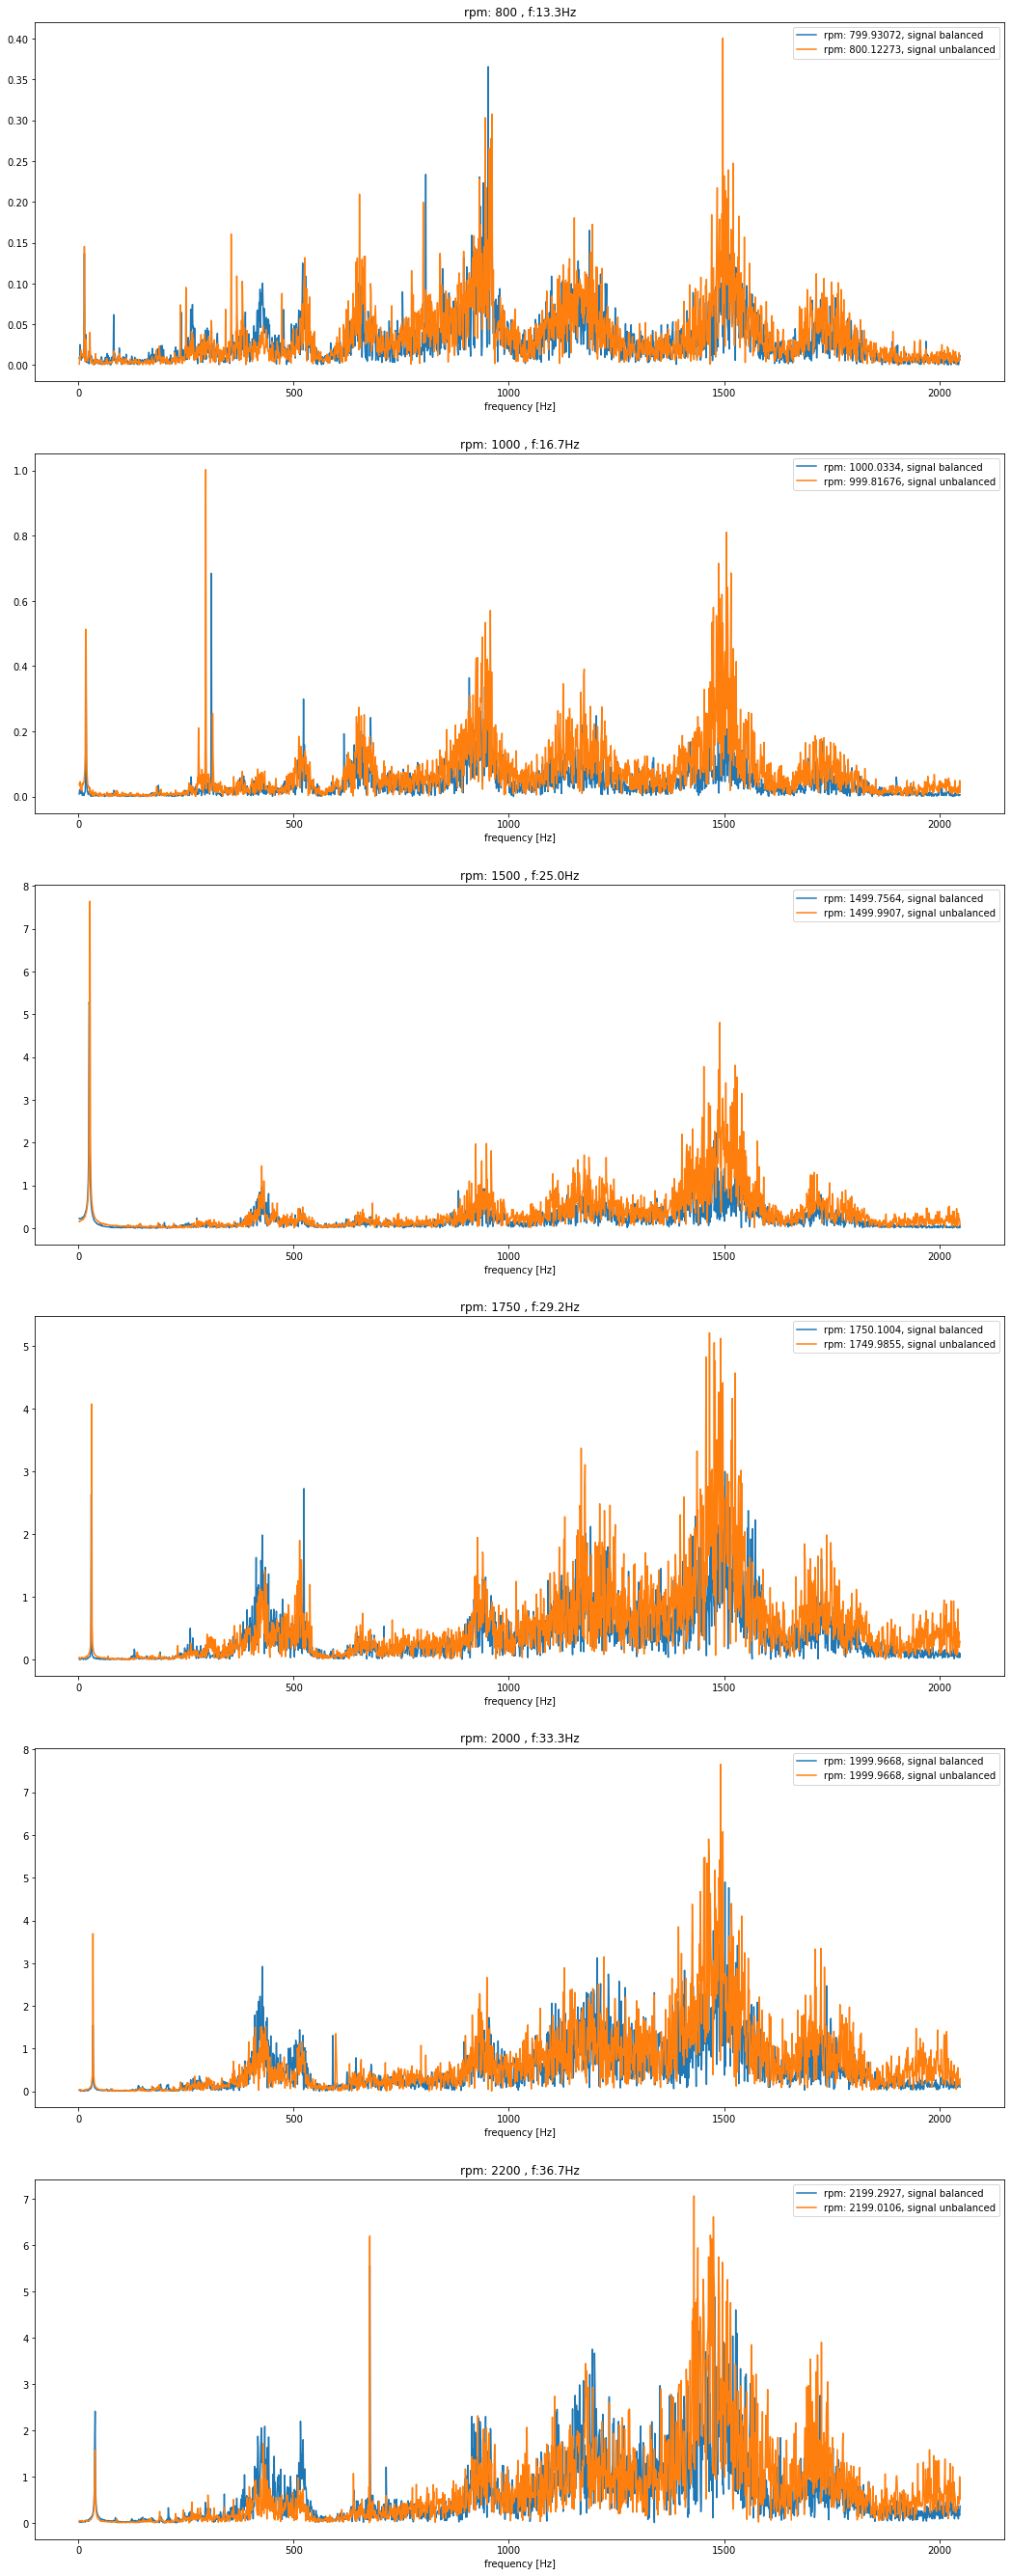

In [ ]:
# visualising chosen signals FFTs

compareFFTs((signals_balanced_d, signals_unbalanced_d), 
            (rpms_balanced_d, rpms_unbalanced_d),
            rpms_to_visualise=[800, 1000, 1500, 1750, 2000, 2200], 
            # rpms=['random' for i in range(5)],
            legend_labels=['balanced', 'unbalanced'],
            signal_length=1.0,
            samplerate=4096,
            # y_lim=[0, 60]
            # x_lim=[0,100]
            )

In [ ]:
# FFTs for all signals

ffts_balanced_d = createFFTArrays(signals_balanced_d)
ffts_unbalanced_d, freqs = createFFTArrays(signals_unbalanced_d, return_freqs=True)

ffts_balanced_e = createFFTArrays(signals_balanced_e)
ffts_unbalanced_e = createFFTArrays(signals_unbalanced_e)

print(f"Shapes:\nffts_balanced_d: {ffts_balanced_d.shape}\nffts_balanced_e:{ffts_balanced_e.shape}")
print(f"\nffts_unbalanced_d: {ffts_unbalanced_d.shape}\nffts_unbalanced_e:{ffts_unbalanced_e.shape}")

Shapes:
ffts_balanced_d: (6068, 2048)
ffts_balanced_e:(1613, 2048)

ffts_unbalanced_d: (6145, 2048)
ffts_unbalanced_e:(1611, 2048)


## Classifiers

### Full dataset preparation

In [ ]:
# train dataset
X_d = np.vstack((ffts_balanced_d, ffts_unbalanced_d))
rpms_d = np.concatenate((rpms_balanced_d, rpms_unbalanced_d))
# 0 - balanced, 1 - unbalanced
y_d = np.array([0 for i in range(len(ffts_balanced_d))] + [1 for i in range(len(ffts_unbalanced_d))])

X_d, y_d, rpms_d = shuffle(X_d, y_d, rpms_d)

# Test dataset
X_test = np.vstack((ffts_balanced_e, ffts_unbalanced_e))
rpms_test = np.concatenate((rpms_balanced_e, rpms_unbalanced_e))
# 0 - balanced, 1 - unbalanced
y_test = np.array([0 for i in range(len(ffts_balanced_e))] + [1 for i in range(len(ffts_unbalanced_e))])

X_test, y_test, rpms_test = shuffle(X_test, y_test, rpms_test)

# validation dataset
val_nb = 2000
# --------------------
# val_size=0.2
# X_train, X_val, y_train, y_val, rpms_train, rpms_val = train_test_split(X_d, y_d, rpms_d, test_size=val_size) 
# --------------
# X_train, X_test, X_val =  X_d[val_nb//2:], X_test[val_nb//2:], np.concatenate((X_d[:val_nb//2], X_test[:val_nb//2])) 
# y_train, y_test, y_val = y_d[val_nb//2:], y_test[val_nb//2:], np.concatenate((y_d[:val_nb//2], y_test[:val_nb//2]))
# rpms_train, rpms_test, rpms_val = rpms_d[val_nb//2:], rpms_test[val_nb//2:], np.concatenate((rpms_d[:val_nb//2], rpms_test[:val_nb//2])) 
# ------------
X_train, X_test, X_val =  X_d[int(val_nb*0.8):], X_test[int(val_nb*0.2):], np.concatenate((X_d[:int(val_nb*0.8)], X_test[:int(val_nb*0.2)])) 
y_train, y_test, y_val = y_d[int(val_nb*0.8):], y_test[int(val_nb*0.2):], np.concatenate((y_d[:int(val_nb*0.8)], y_test[:int(val_nb*0.2)]))
rpms_train, rpms_test, rpms_val = rpms_d[int(val_nb*0.8):], rpms_test[int(val_nb*0.2):], np.concatenate((rpms_d[:int(val_nb*0.8)], rpms_test[:int(val_nb*0.2)])) 
# ------------------------

print("shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")


shapes:
X_train: (10613, 2048)
X_val: (2000, 2048)
X_test: (2824, 2048)


#### Normalise datasets

In [ ]:
def normaliseDataset(dataset, normalisation_params=None, return_normalisation_params=False):
    """ Function normalises dataset to range [0, 1] w.r.t. its coefficients minimums/maximums 
    if the normalisation parameters are not given or to given normalisation_params
    ---
    args:
        dataset:                        dataset to be normalised
        normalisation_params:           default=None, parameters w.r.t which the dataset will be normalised
        return_normalisation_params:    default=False
    ---
    return:
        dataset_normal:         normalised dataset
        normalisation_params:   dictionary with the parameters of the performed normalisation, 
                                used when other datasets have to be normalised with same parameters
    """
    if normalisation_params == None:
        coef_mins = np.min(dataset, axis=0)
        coef_maxes = np.max(dataset, axis=0)
    else:
        coef_mins = normalisation_params['coef_mins']
        coef_maxes = normalisation_params['coef_maxes']


    # normalise all samples
    dataset_normal = (dataset - coef_mins) / (coef_maxes - coef_mins)

    if return_normalisation_params:
        normalisation_params = {"coef_mins": coef_mins,
                                "coef_maxes": coef_maxes}
        return dataset_normal, normalisation_params
    else:
        return dataset_normal

def scaleDataset(dataset, scale_params=None, return_scale_params=False):
    """Function scales the dataset by substracting the median of each Fourier coefficient and then 
    dividing the value by the interquantile range (quantiles 5 and 95)
    ---
    args:
        dataset:                dataset to be scaled
        scale_params:           default=None, parameters w.r.t which the dataset will be scaled
        return_scale_params:    default=False
    ---
    return:
        dataset_scaled:         normalised dataset
        scale_params:           dictionary with the parameters of the performed normalisation, 
                                used when other datasets have to be normalised with same parameters
    """
    if scale_params == None:
        medians = np.median(dataset, axis=0)
        quantiles_5 = np.quantile(dataset, 0.05, axis=0) 
        quantiles_95 = np.quantile(dataset, 0.95, axis=0) 
        interquantile_ranges = quantiles_95 - quantiles_5
    else:
        medians = scale_params['medians']
        quantiles_5 = scale_params['quantiles_5']
        quantiles_95 = scale_params['quantiles_95']
        interquantile_ranges = scale_params['interquantile_ranges']

    # scale all samples
    dataset_scaled = (dataset - medians) / interquantile_ranges

    if return_scale_params:
        scale_params = {"medians": medians, 
                        "quantiles_5": quantiles_5, 
                        "quantiles_95": quantiles_95, 
                        "interquantile_ranges": interquantile_ranges}
        return dataset_scaled, scale_params
    else:
        return dataset_scaled

In [ ]:
# scale and normalise all datasets w.r.t. the parameters from training dataset

X_train, scale_params = scaleDataset(X_train, return_scale_params=True)
X_val = scaleDataset(X_val, scale_params=scale_params)
X_test = scaleDataset(X_test, scale_params=scale_params)

X_train, normalisation_params = normaliseDataset(X_train, return_normalisation_params=True)
X_val = normaliseDataset(X_val, normalisation_params=normalisation_params)
X_test = normaliseDataset(X_test, normalisation_params=normalisation_params)

### Building a model

In [ ]:
def buildModel(input_shape,
               output_shape=1,
               neurons=[128],
               activation="relu",
               dropouts=None,
               optimizer='adam'
               ):
    """ Function builds a whole classifier
    ---
    args:
        input_shape:    shape of an input vector
        output_shape:   number of classes 
        neurons:        list of neurons numbers for each layer
        activation:     activation function for each layer
        dropouts:        a value of dropout for all layers 
                            (if None then there is no dropout layer) -> list
        optimizer:      default='adam'
    ---
    returns:
        model:      already build and compiled model, rescaling to 0-1 range, 
                    Input and output layers, compilation parameters:
                        - loss='binary_crossentropy', 
                        - metrics=['accuracy']
    """
    layers_nb = len(neurons)
    model = Sequential()
    # input layer
    model.add(keras.Input(shape=input_shape))
    # hidden layers
    for layer_neurons in neurons:
        if activation == "LeakyReLU":
            model.add(layers.Dense(layer_neurons))
            model.add(LeakyReLU(alpha=0.05))    
        else:
            model.add(layers.Dense(layer_neurons, activation=activation))
    # output layer
    model.add(layers.Dense(output_shape, activation="sigmoid"))

    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
                  )

    return model

## Random Search

In [ ]:
# parameters to check
neurons = [[32, 16],
           [64, 32],
           [128, 64],
           [64, 32, 16],
           [128, 64, 32],
           [256, 128, 64]]

activations = ["relu", "selu", "LeakyReLU"]
batch_sizes = [16, 32, 64, 128]
dropouts = [None, 0.2, 0.5]
optimizers = ['adam', 'rmsprop']

nb_combinations = len(list(product(neurons, activations, batch_sizes, dropouts, optimizers)))


params = dict(
	model__neurons=neurons,
    model__activation=activations,
    model__dropouts=dropouts,
    batch_size=batch_sizes,
    optimizer=optimizers
)

print(f"number of combinations: {nb_combinations}")
params

number of combinations: 432


{'model__neurons': [[32, 16],
  [64, 32],
  [128, 64],
  [64, 32, 16],
  [128, 64, 32],
  [256, 128, 64]],
 'model__activation': ['relu', 'selu', 'LeakyReLU'],
 'model__dropouts': [None, 0.2, 0.5],
 'batch_size': [16, 32, 64, 128],
 'optimizer': ['adam', 'rmsprop']}

In [ ]:
# preparation of dataset to use in RandomisedSearchCV
# more info here: https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn
# merging train and validation sets
X_RS = np.vstack([X_train, X_val])
y_RS = np.concatenate([y_train, y_val])
# preparing test_fold array - -1 training samples, 0 - validation samples
test_fold = [-1 for i in range(X_train.shape[0])] + [0 for i in range(X_val.shape[0])]
# predefined validation fold
ps = PredefinedSplit(test_fold=test_fold)


# wrap model into a scikit-learn compatible classifier
search_model = KerasClassifier(model=buildModel,
                               verbose=0,
                               input_shape=X_train.shape[1],
                               output_shape=1,
                               )

random_search = RandomizedSearchCV(estimator=search_model,
                                   param_distributions=params,
                                   n_iter=50,
                                   n_jobs=1,
                                   scoring="accuracy",
                                   error_score='raise',
                                   return_train_score=True,
                                   verbose=0,
                                   cv=ps # predefined validation split
                                   )

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           verbose=0,
                                           patience=3,
                                        )]


search_results = random_search.fit(X_RS,
                                   y_RS,
                                   epochs=50,
                                   callbacks=callbacks,
                                   )

# clear_output()

# summarize grid search information
best_score = search_results.best_score_
best_params = search_results.best_params_
print(f"best score: {best_score:.3f}\nbest parameters: {best_params}")

del X_RS, y_RS

In [ ]:
# # # Save results
# # # ------------------------------------------------------------------------
# search_results_table = pd.DataFrame(search_results.cv_results_)
# # adding a column for neurons as strings so that they can be visualised in catplot
# search_results_table["param_model__neurons_str"] = search_results_table["param_model__neurons"].astype(str)
# search_results_table["param_model__activation_str"] = search_results_table["param_model__activation"].astype(str)
# search_results_table["param_model__dropouts_str"] = search_results_table["param_model__dropouts"].astype(str)

# # save results on google drive
# search_results_table.to_excel('/content/drive/My Drive/data_extension_GANs/randomized_search_results.xlsx')
# # save best model params as json file
# with open('/content/drive/My Drive/data_extension_GANs/best_model_params.json', "w") as fp:
#     json.dump(best_params,fp)

# # Load results
# # ------------------------------------------------------------------------
# load result table
search_results_table = pd.read_excel('/content/drive/My Drive/data_extension_GANs/randomized_search_results.xlsx', index_col=0)
# load best model params
with open('/content/drive/My Drive/data_extension_GANs/best_model_params.json') as json_file:
    best_params = json.load(json_file)

print(f"best_params: {best_params}")

search_results_table

best_params: {'optimizer': 'rmsprop', 'model__neurons': [128, 64, 32], 'model__dropouts': 0.5, 'model__activation': 'selu', 'batch_size': 32}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_model__neurons,param_model__dropouts,param_model__activation,param_batch_size,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score,param_model__neurons_str,param_model__activation_str,param_model__dropouts_str
0,76.660951,0,0.243407,0,adam,"[64, 32, 16]",0.5,relu,16,"{'optimizer': 'adam', 'model__neurons': [64, 3...",0.9735,0.9735,0,29,0.999554,0.999554,0,"[64, 32, 16]",relu,0.5
1,142.785254,0,0.398348,0,adam,"[256, 128, 64]",0.5,LeakyReLU,16,"{'optimizer': 'adam', 'model__neurons': [256, ...",0.9615,0.9615,0,37,0.999554,0.999554,0,"[256, 128, 64]",LeakyReLU,0.5
2,41.711649,0,0.139177,0,adam,"[32, 16]",0.2,selu,64,"{'optimizer': 'adam', 'model__neurons': [32, 1...",0.9560,0.9560,0,41,0.999376,0.999376,0,"[32, 16]",selu,0.2
3,61.980903,0,0.238941,0,rmsprop,"[32, 16]",0.5,selu,16,"{'optimizer': 'rmsprop', 'model__neurons': [32...",0.9815,0.9815,0,21,0.999465,0.999465,0,"[32, 16]",selu,0.5
4,21.205594,0,0.115608,0,adam,"[64, 32]",0.5,LeakyReLU,128,"{'optimizer': 'adam', 'model__neurons': [64, 3...",0.9245,0.9245,0,49,0.999554,0.999554,0,"[64, 32]",LeakyReLU,0.5
5,41.694827,0,0.141898,0,rmsprop,"[64, 32, 16]",0.2,selu,64,"{'optimizer': 'rmsprop', 'model__neurons': [64...",0.9830,0.9830,0,15,0.999554,0.999554,0,"[64, 32, 16]",selu,0.2
6,87.067967,0,0.227686,0,adam,"[256, 128, 64]",0.2,LeakyReLU,32,"{'optimizer': 'adam', 'model__neurons': [256, ...",0.9865,0.9865,0,13,0.999465,0.999465,0,"[256, 128, 64]",LeakyReLU,0.2
7,82.724400,0,0.239296,0,rmsprop,"[64, 32, 16]",0.5,LeakyReLU,32,"{'optimizer': 'rmsprop', 'model__neurons': [64...",0.9820,0.9820,0,17,0.999554,0.999554,0,"[64, 32, 16]",LeakyReLU,0.5
8,82.651937,0,0.228060,0,rmsprop,"[32, 16]",0.5,relu,16,"{'optimizer': 'rmsprop', 'model__neurons': [32...",0.9760,0.9760,0,26,0.999554,0.999554,0,"[32, 16]",relu,0.5
9,42.785213,0,0.161918,0,rmsprop,"[256, 128, 64]",0.2,selu,128,"{'optimizer': 'rmsprop', 'model__neurons': [25...",0.9745,0.9745,0,28,0.999554,0.999554,0,"[256, 128, 64]",selu,0.2


In [ ]:
def visualiseSearchResults(search_results, params):
    """ Function displays catplots showing accuracies obtained for different parameters
    ---
    args:
        search_results:     pd.DataFrame with search results
        params:             dictionary of parameters used in RandomisedSearchCV / GridSearchCV
    """
    for i, param in enumerate(params.keys()):
        if param in ['model__neurons', 'model__activation', 'model__dropouts']:
            param = param +'_str'
        param = 'param_' + param
        
        param_vals = search_results_table[param].unique()
        mean_scores = [search_results_table.loc[search_results_table[param] == param_val].mean_test_score.mean() for param_val in param_vals]
        legend_labels = []

        for param_val, mean_score in zip(param_vals, mean_scores):
            legend_labels.append(f"{param_val}, mean accuracy = {mean_score:.4f}")

        plt.figure(i)
        sns.catplot(x = param, y='mean_test_score', data=search_results, s=8, height=4, aspect=3)
        plt.ylabel('mean accuracy')
        plt.legend(legend_labels)
        plt.grid()
        plt.show()

<Figure size 432x288 with 0 Axes>

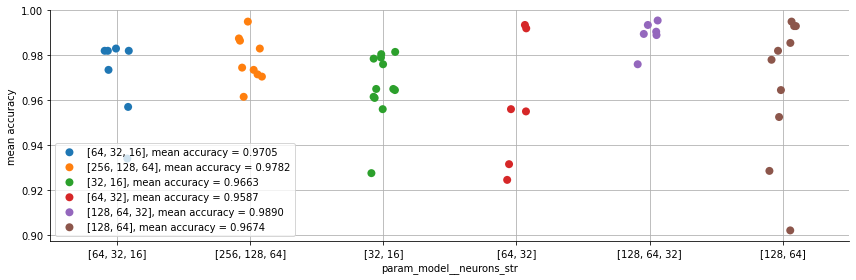

<Figure size 432x288 with 0 Axes>

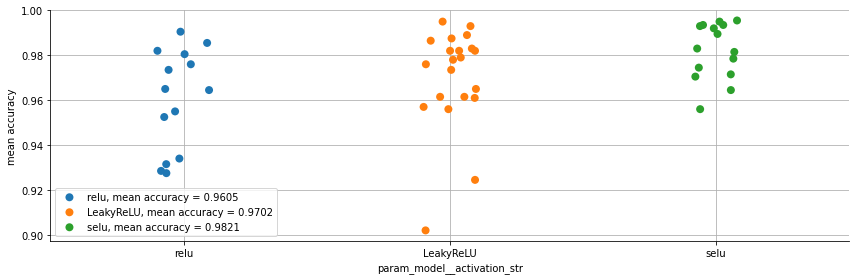

<Figure size 432x288 with 0 Axes>

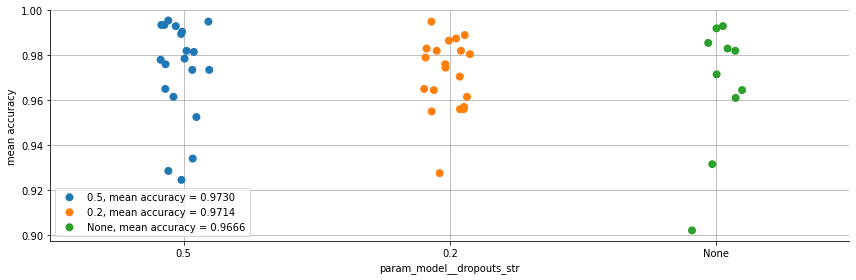

<Figure size 432x288 with 0 Axes>

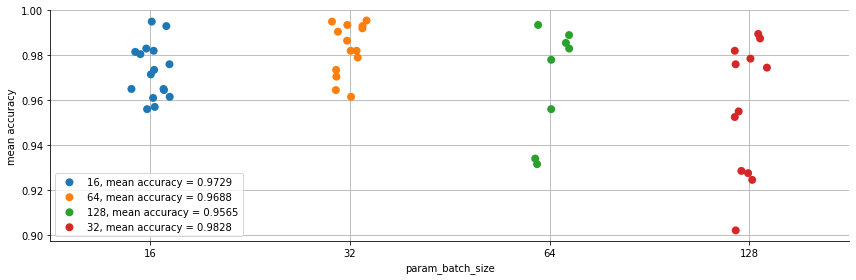

<Figure size 432x288 with 0 Axes>

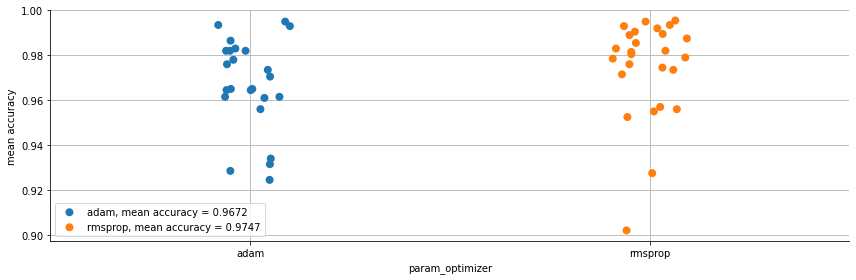

In [ ]:
visualiseSearchResults(search_results_table, params)

## Final Model (optimised parameters)

In [ ]:
balance_clf = buildModel(input_shape=X_train.shape[1],
                         output_shape=1,
                         neurons=best_params["model__neurons"],
                         activation=best_params["model__activation"],
                         dropouts=best_params["model__dropouts"],
                         optimizer=best_params["optimizer"])
balance_clf.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 272,641
Trainable params: 272,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           verbose=0,
                                           patience=10,
                                           restore_best_weights=True
                                        )] 

history = balance_clf.fit(X_train, 
                          y_train, 
                          batch_size=best_params["batch_size"], 
                          validation_data=[X_val, y_val], 
                          epochs=50, 
                          callbacks=callbacks)

Epoch 1/50
332/332 [==============================] - 2s 5ms/step - loss: 0.2044 - accuracy: 0.9194 - val_loss: 0.0459 - val_accuracy: 0.9850
Epoch 2/50
332/332 [==============================] - 1s 4ms/step - loss: 0.0410 - accuracy: 0.9892 - val_loss: 0.0143 - val_accuracy: 0.9950
Epoch 3/50
332/332 [==============================] - 1s 4ms/step - loss: 0.0342 - accuracy: 0.9929 - val_loss: 0.0102 - val_accuracy: 0.9955
Epoch 4/50
332/332 [==============================] - 1s 4ms/step - loss: 0.0357 - accuracy: 0.9944 - val_loss: 0.0140 - val_accuracy: 0.9940
Epoch 5/50
332/332 [==============================] - 1s 4ms/step - loss: 0.0299 - accuracy: 0.9954 - val_loss: 0.0234 - val_accuracy: 0.9900
Epoch 6/50
332/332 [==============================] - 1s 4ms/step - loss: 0.0224 - accuracy: 0.9949 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 7/50
332/332 [==============================] - 1s 4ms/step - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.0104 - val_accuracy: 0.9940
Epoch 

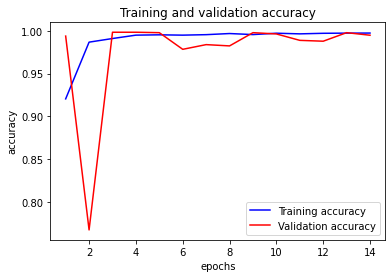

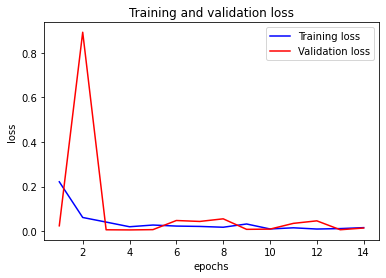

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel('epochs')
plt.ylabel("accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel("loss")
plt.show()

### Test set evaluation

In [ ]:
balance_clf.evaluate(X_test, y_test)

89/89 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9897


[0.024173934012651443, 0.9897308945655823]

### Analysis of the impact of training set size on the model performance

In [ ]:
def reduceDataset(dataset, dataset_size=1.0):
    """ Function reduces given dataset to the given size (note: the dataset should be shuffled before)
    ---
    args:
        dataset:
        dataset_size:   default=1.0
    ---
    returns:    
        dataset_red
    """
    trim_id = int(dataset_size * dataset.shape[0])
    dataset_red = np.copy(dataset[:trim_id])

    return dataset_red

In [ ]:
dataset_sizes = [1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.025]
accuracies = []


for dataset_size in dataset_sizes:
    # prepare reduced dataset
    X_red = reduceDataset(X_train, dataset_size=dataset_size)
    y_red = reduceDataset(y_train, dataset_size=dataset_size)
    # build model
    reduced_dataset_model = buildModel(input_shape=X_train.shape[1], 
                                       output_shape=1, 
                                       neurons=best_params["model__neurons"], 
                                       activation=best_params["model__activation"], 
                                       dropouts=best_params["model__dropouts"], 
                                       optimizer=best_params["optimizer"])
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           verbose=0,
                                           patience=5,
                                           restore_best_weights=True
                                        )] 

    history = reduced_dataset_model.fit(X_red, 
                                        y_red, 
                                        batch_size=best_params["batch_size"], 
                                        validation_data=[X_val, y_val], 
                                        epochs=50, 
                                        callbacks=callbacks, 
                                        verbose=0)
    # accuracy = np.max(history.history["val_accuracy"])
    loss, accuracy = reduced_dataset_model.evaluate(X_test, y_test, verbose=0)
    print(f"trainset_size_factor: {dataset_size}, samples_number: {X_red.shape[0]}, accuracy: {accuracy:.5f}")
    accuracies.append(accuracy)

del X_red, y_red

trainset_size_factor: 1.0, samples_number: 10613, accuracy: 0.98938
trainset_size_factor: 0.75, samples_number: 7959, accuracy: 0.98477
trainset_size_factor: 0.5, samples_number: 5306, accuracy: 0.99150
trainset_size_factor: 0.25, samples_number: 2653, accuracy: 0.97769
trainset_size_factor: 0.1, samples_number: 1061, accuracy: 0.97025
trainset_size_factor: 0.05, samples_number: 530, accuracy: 0.92033
trainset_size_factor: 0.025, samples_number: 265, accuracy: 0.85659


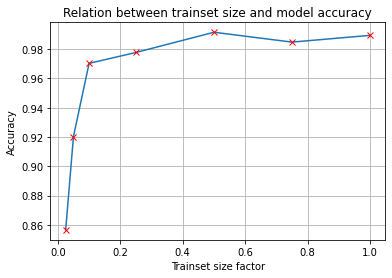

In [ ]:
plt.figure()
plt.plot(dataset_sizes, accuracies, '-', dataset_sizes, accuracies, 'xr')
plt.ylabel('Accuracy')
plt.xlabel('Trainset size factor')
plt.title('Relation between trainset size and model accuracy')
plt.grid()
plt.show()

## Trainset reduction and data augmentation tests

As we can see on last graph, if we take less than $10\%$ of original dataset, the accuracy of the trained model drops below $95\%$. In this section I will try to increase the performance of the model trained on $5\%$ of the training dataset using data augmentation

In [ ]:
# reducing dataset
dataset_size = 0.05

X_red = reduceDataset(X_train, dataset_size=dataset_size)
y_red = reduceDataset(y_train, dataset_size=dataset_size)

In [ ]:
# # Save reduced datset split for later use
# np.savetxt("/content/drive/My Drive/data_extension_GANs/X_red.csv", X_red, delimiter=',')
# np.savetxt("/content/drive/My Drive/data_extension_GANs/y_red.csv", y_red, delimiter=',')

# Load reduced datset
X_red = np.loadtxt("/content/drive/My Drive/data_extension_GANs/X_red.csv", delimiter=',')
y_red = np.loadtxt("/content/drive/My Drive/data_extension_GANs/y_red.csv", delimiter=',')

The method used for Data Augmentation in this project was to train two seperate GANs, on two different labels, so that each of them will later produce samples belonging to different labels

In [ ]:
# dividing labels for use in 2 different GANs

# balanced signals (0)
idx_b = np.where(y_red == 0)
X_red_b = X_red[idx_b]
y_red_b = y_red[idx_b]

# unbalanced signals (1)
idx_u = np.where(y_red == 1)
X_red_u = X_red[idx_u]
y_red_u = y_red[idx_u]

### Generative Adversial Networks

In [ ]:
# Size of the noise vector, used as input to the Generator
z_dim = 100

sample_size = X_red.shape[1]

In [ ]:
# -----------------
# Generator
# -----------------

def buildGenerator(sample_size, z_dim, nb_of_layers=1, output_activation='sigmoid', alpha=0.1):
    """ Function builds a generator of GAN
    ---
    args:
        sample_size:        size of single sample that generator should produce
        z_dim:              Size of the noise vector
        nb_of_layers:       default=1, each layer has 128 * 2^i neurons, where i is the layer number
        output_activation:  default='sigmoid', also available 'tanh'
        alpha:              default=0.1  
    ---
    results:
        gen:        generator

    """
    gen = Sequential(name='generator')

    # input layer
    gen.add(keras.Input(shape=z_dim))

    # hidden layers
    for i in range(nb_of_layers):
        gen.add(layers.Dense(128 * 2**i))
        # batch normalization - causes problems
        # gen.add(layers.BatchNormalization())
        # Leaky ReLU activation
        gen.add(LeakyReLU(alpha=alpha))
    
    # Output layer
    gen.add(layers.Dense(sample_size, activation=output_activation))


    return gen

# -----------------
# Discriminator
# -----------------

def buildDiscriminator(sample_size, nb_of_layers=1, alpha=0.1):
    """ Function builds a discriminator of GAN
    ---
    args:
        sample_size:        size of single sample that the discriminator is fed with
        nb_of_layers:       default=1, each layer has 128 * 2^i neurons, where i is the layer number
        alpha:              default=0.1  
    ---
    results:
        gen:        discriminator

    
    """
    disc = Sequential(name="discriminator")

    # input layer
    disc.add(keras.Input(shape=sample_size))

    # hidden layers
    for i in range(nb_of_layers, 0, -1):
        disc.add(layers.Dense(128 * 2**i))
        # batch normalization
        # disc.add(layers.BatchNormalization())
        # Leaky ReLU activation
        disc.add(LeakyReLU(alpha=alpha))

     # Output layer with sigmoid activation
    disc.add(layers.Dense(1, activation='sigmoid'))

    # compile discriminator
    disc.compile(loss='binary_crossentropy',
                      optimizer="adam",
                      metrics=['accuracy'])

    return disc

# -----------------
# GAN
# -----------------
def buildGAN(sample_size, 
             z_dim=100, 
             gen_layers=1, 
             disc_layers=1, 
             gen_output_activation='sigmoid',
             alpha=0.1):
    """ function builds and compiles a GAN
    ---
    args:
        sample_size:            size of single sample
        z_dim:                  default=100, Size of the noise vector
        gen_layers:             default=1, layer number of Generator
        disc_layers:            default=1, layer number of Discriminator
        gen_output_activation:  default='sigmoid',
        alpha:                  default=0.1
    ---
    returns:
        gan:            fully built and compiled Generative Adversarial Network, ready to train
    """
    # build and compile discriminator
    disc = buildDiscriminator(sample_size, 
                              nb_of_layers=disc_layers, 
                              alpha=alpha)
    
    # build a generator
    gen = buildGenerator(sample_size, 
                         z_dim=z_dim, 
                         nb_of_layers=gen_layers, 
                         output_activation=gen_output_activation, 
                         alpha=alpha)
    
    gen.summary()
    disc.summary()
    # Keep Discriminator’s parameters constant for Generator training
    disc.trainable = False


   # Build and compile GAN model with fixed Discriminator to train the Generator
    gan = Sequential([gen, disc])
    gan.compile(loss='binary_crossentropy', optimizer="adam")

    return gan

# -----------------
# Training GAN
# -----------------

def trainGAN(gan, 
             X,
             freqs,
             iter=1000,
             batch_size=32,
             log_interval=100,
             z_dim=100,
             verbose=False,
             gen_output_activation='tanh',
             gen_training_freq=1,
             disc_training_freq=1,
             ):
    """ Function performs a training of the given GAN, 
    (Most of the function copied from Langr, Jakub, and Vladimir Bok. GANs in Action. Manning Publications, 2019)
    ---
    args:
        gan:                    Generative Adversarial Network to be trained               
        X:                      Training set for GAN
        freqs                   list of FFT frequencies for visualisation
        iter:                   default=1000, number of training iterations  
        batch_size:             default=32
        log_interval:           default=100, 
        z_dim                   default=100,
        verbose                 default=False,
        gen_output_activation:  default='tanh'
        gen_training_freq:      default=1,  number of training iterations of generator 
                                            for 1 training iteration of discriminator
        disc_training_freq:     default=1,  number of training iterations of discriminator
                                            for 1 training iteration of generator
    ---
    returns:
        gan             trained Generative Adversarial Network
        metrics         dictionary with training history ({"losses": losses,
                                                           "accuracies": accuracies,
                                                           "iteration_checkpoints": iteration_checkpoints})
    """
    # prepare the metrics
    losses = []
    accuracies = []
    iteration_checkpoints = []

    # # rescale X if activation function of geneerator is tanh [0,1] -> [-1,1]
    if gen_output_activation == 'tanh':
        X = X*2 - 1

    # Labels for real images: all ones 
    real_y = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake_y = np.zeros((batch_size, 1))

    # extract generator and disciminator
    gen, disc = gan.layers
    
    for iteration in range(iter):

        # ------------------------
        # Train the Discrimator
        # ------------------------

        for i in range(disc_training_freq):
            #  Get a random batch of real images
            idx = np.random.randint(0, X.shape[0], batch_size)
            real_samples = X[idx]

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            gen_samples = gen.predict(z, verbose=0)

            # Train Discriminator
            d_loss_real = disc.train_on_batch(real_samples, real_y)
            d_loss_fake = disc.train_on_batch(gen_samples, fake_y)
            d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Train Generator (label fakes as real at this stage)
        # gen_training_freq, try training generator more times than the discriminator
        for i in range(gen_training_freq):
            z = np.random.normal(0, 1, (batch_size, z_dim))
            g_loss = gan.train_on_batch(z, real_y)

        if (iteration + 1) % log_interval == 0:

            # Save losses and accuracies so they can be plotted after training            
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            if verbose:
                # Output training progress
                print(f"{iteration+1}/{iter}: [D loss: {d_loss}, acc: {100.0 * accuracy}\%]  [G loss: {g_loss}]")
                
                # TEST___________________ check if discriminator is training or not
                # print(f"disc_weights: {disc.get_weights()[0][1][1]}")


                # Output a sample of generated spectrum
                sample_spectrums(gen, freqs, gen_output_activation=gen_output_activation)

        metrics = {"losses": losses,
                   "accuracies": accuracies,
                   "iteration_checkpoints": iteration_checkpoints}


    return gan, metrics

def sample_spectrums(gen, freqs, image_grid_rows=4, image_grid_columns=4, gen_output_activation='sigmoid'):
    """ Function produces and visualises fake samples with GAN
    ---
    args:
        gen:                    generator
        freqs:                  list of FFT frequencies for visualisation
        image_grid_rows:        default=4
        image_grid_columns:     default=4
        gen_output_activation   default='sigmoid'
    """
    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_samples = gen.predict(z, verbose=0)

    if gen_output_activation == 'tanh':
        gen_samples = (gen_samples+1)/2

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 10),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].plot(freqs, gen_samples[cnt,:])
            # axs[i, j].axis('off')
            cnt += 1

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_981 (Dense)           (None, 128)               12928     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_982 (Dense)           (None, 2048)              264192    
                                                                 
Total params: 277,120
Trainable params: 277,120
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_978 (Dense)           (None, 512)               1049088   
                                                                 
 leaky_re_lu_18 (LeakyReLU) 

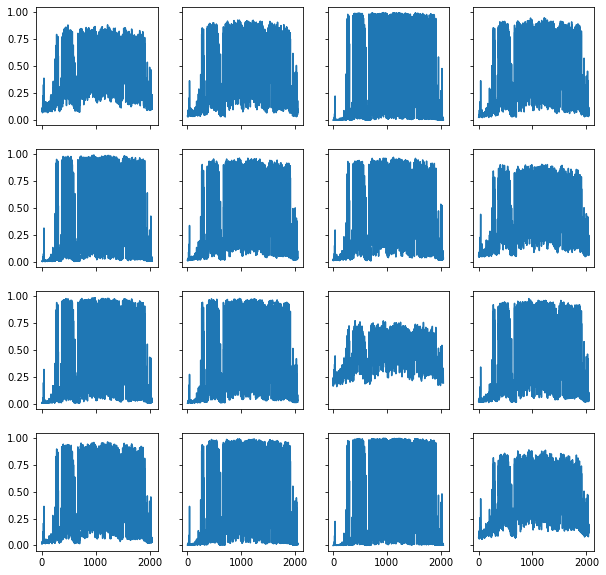

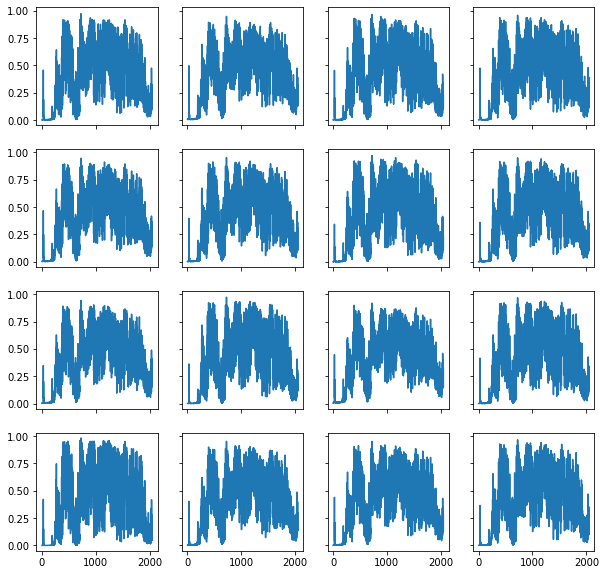

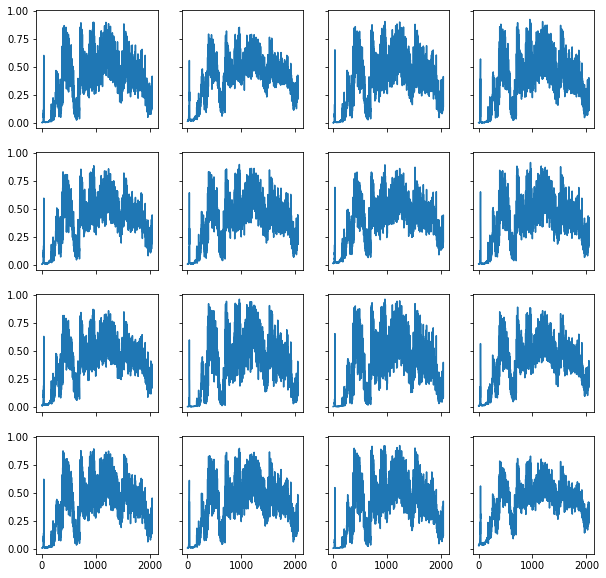

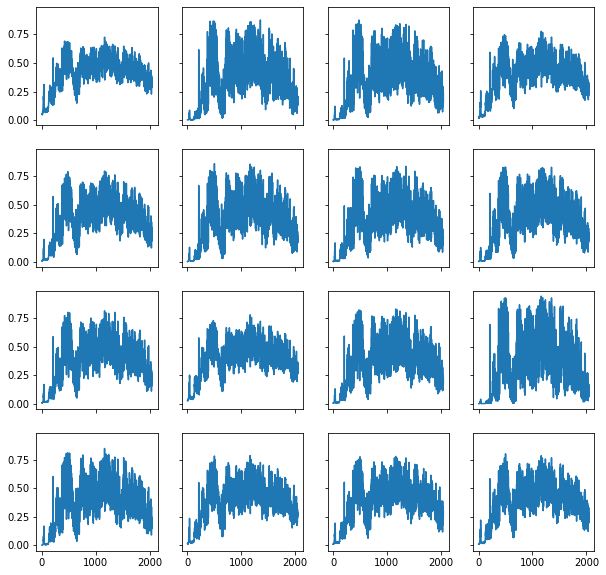

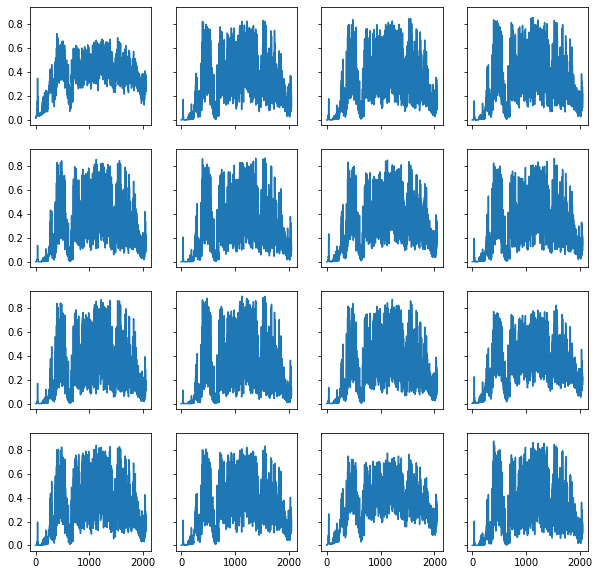

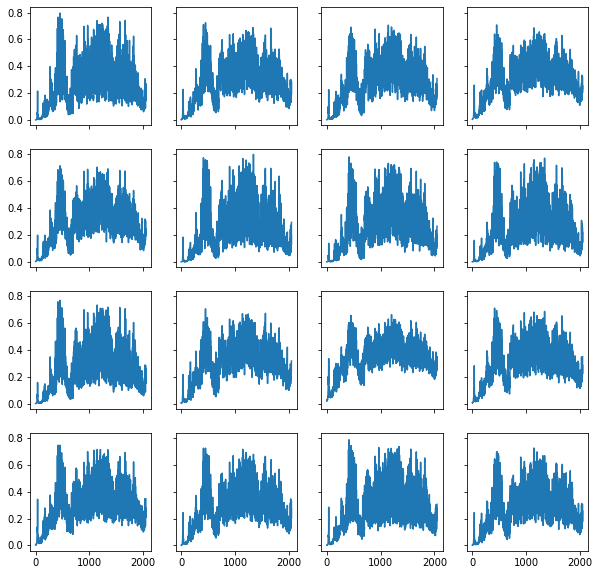

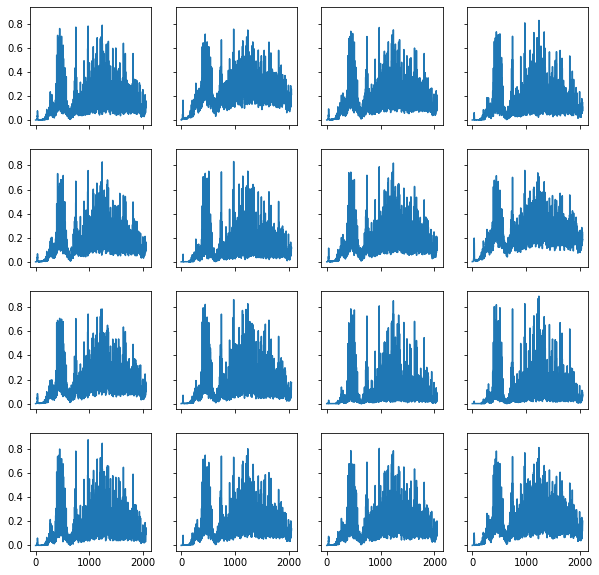

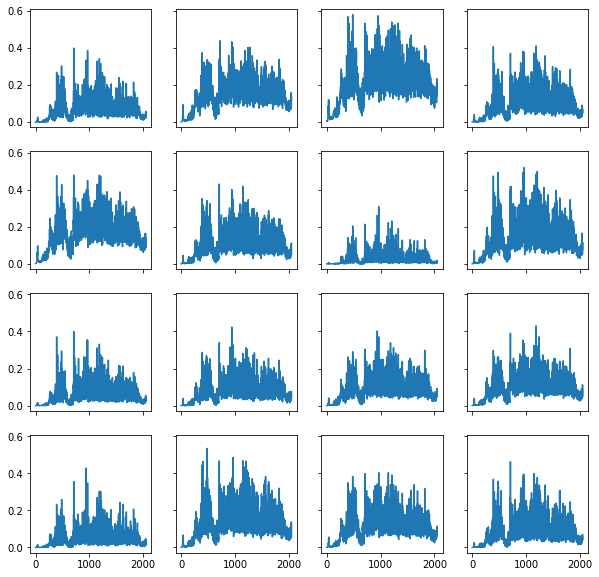

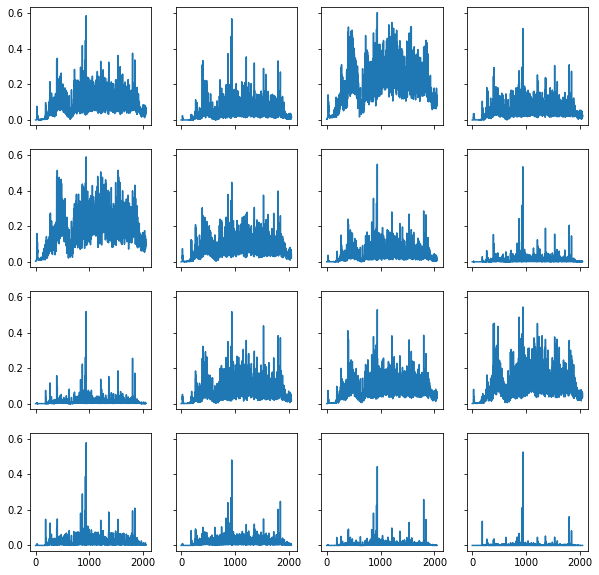

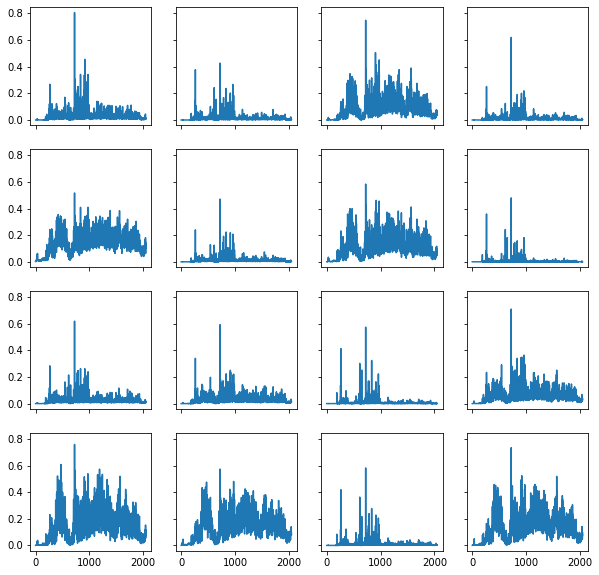

In [ ]:
# Set hyperparameters
iterations = 10000
batch_size = 32
log_interval = iterations//10
gen_output_activation_b = "sigmoid" # "sigmoid", "tanh"
gen_layers_b = 1
disc_layers_b = 2
# How many generator training iterations should be performed 
# for 1 training iteration of discriminator and vice versa
gen_training_freq = 1
disc_training_freq = 1

gan_parameters_b = {"label": "b",
                    "gen_output_activation": gen_output_activation_b,
                    "gen_layers": gen_layers_b,
                    "disc_layers": disc_layers_b,
                    "gen_training_freq": gen_training_freq}

# build gan
# For continuing training comment buildGAN line
gan_b = buildGAN(sample_size=2048, 
                z_dim=100, 
                gen_layers=gen_layers_b, 
                disc_layers=disc_layers_b, 
                gen_output_activation=gen_output_activation_b, 
                alpha=0.1)

# Train the GAN for the specified number of iterations
gan_b, metrics_b = trainGAN(gan_b, 
                            X_red_b, 
                            freqs, 
                            iter=iterations, 
                            batch_size=batch_size, 
                            log_interval=log_interval, 
                            z_dim=100, 
                            verbose=True, 
                            gen_output_activation=gen_output_activation_b, 
                            gen_training_freq=gen_training_freq,
                            disc_training_freq=disc_training_freq)

generator_b = gan_b.layers[0]

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               12928     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 2048)              264192    
                                                                 
Total params: 277,120
Trainable params: 277,120
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               1049088   
                                                                 
 leaky_re_lu_9 (LeakyReLU)  

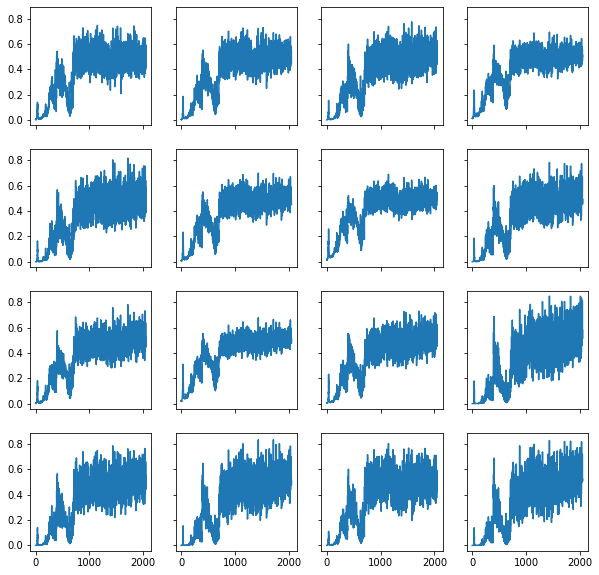

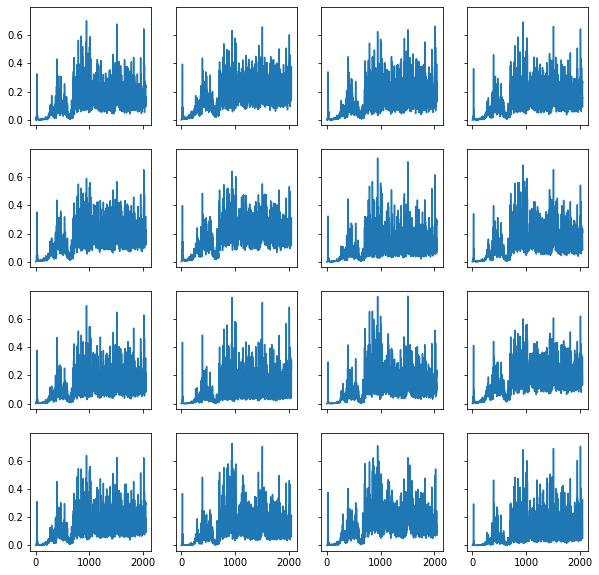

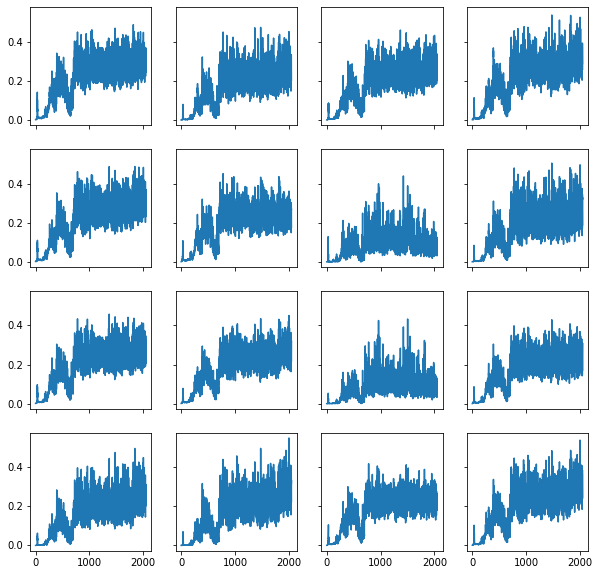

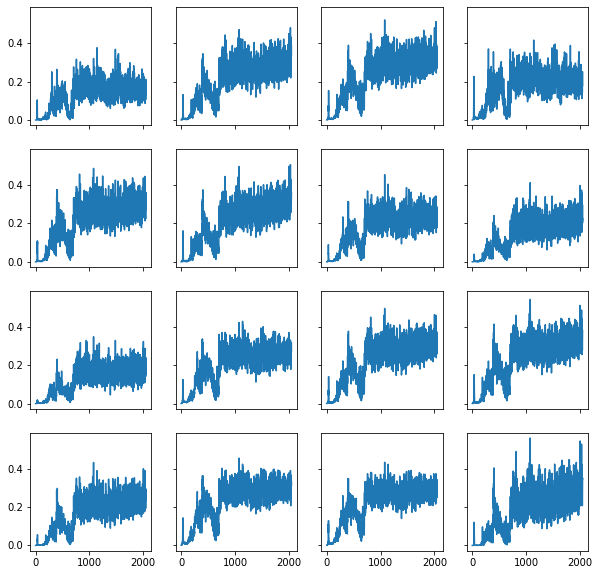

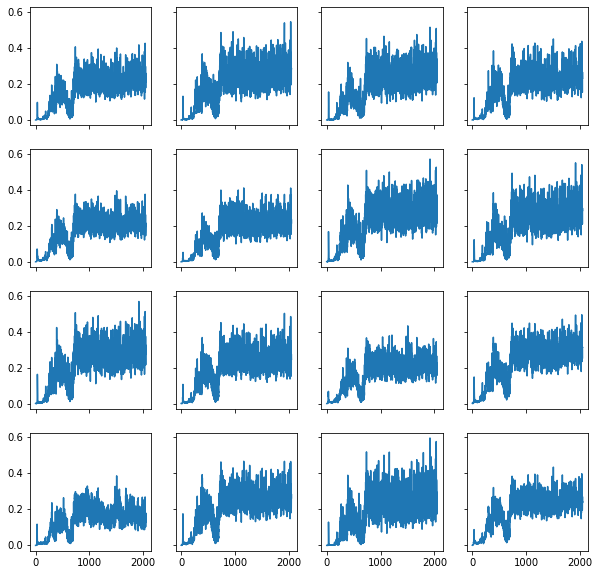

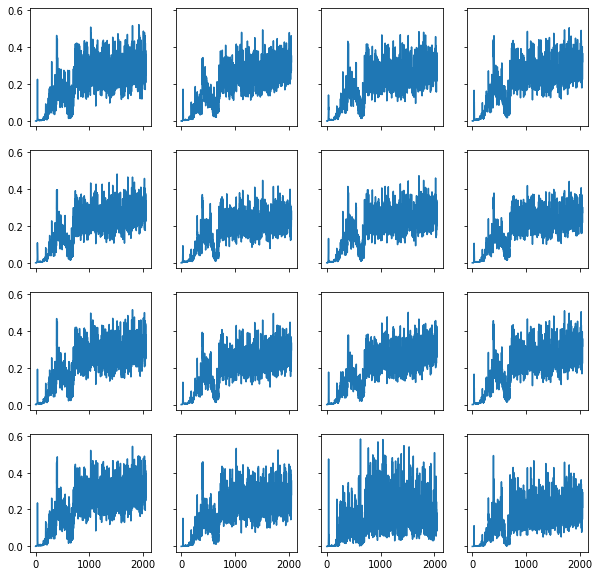

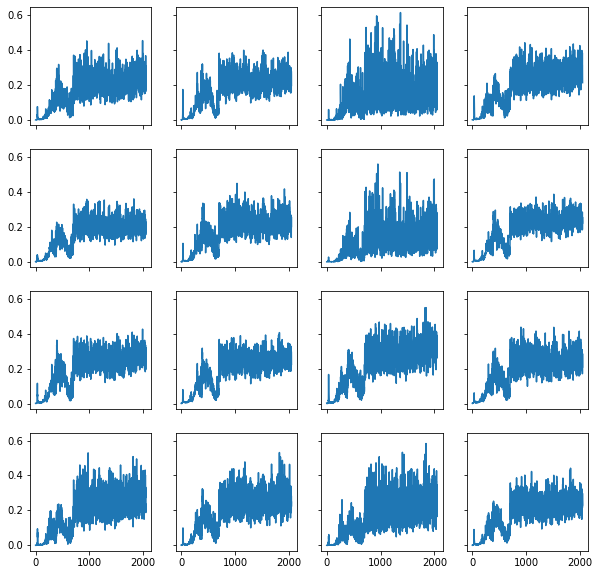

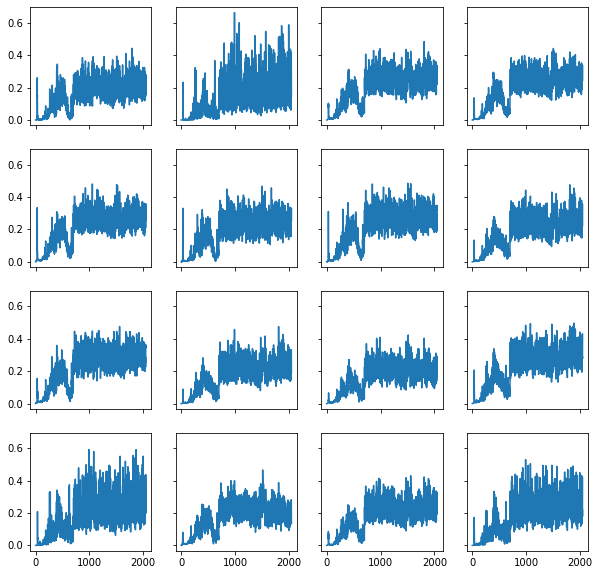

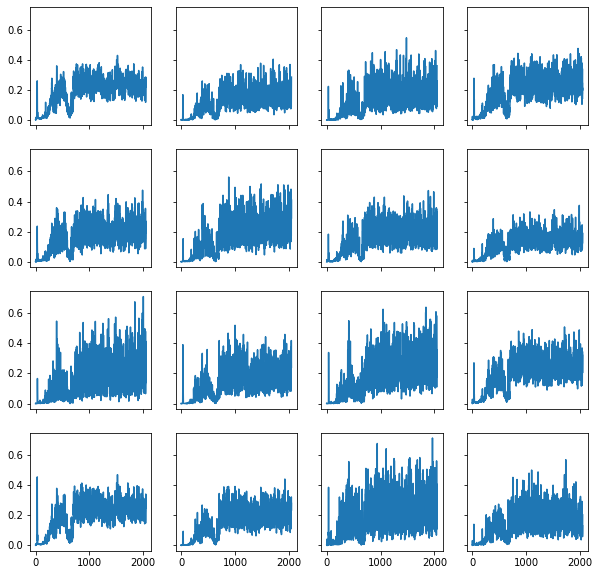

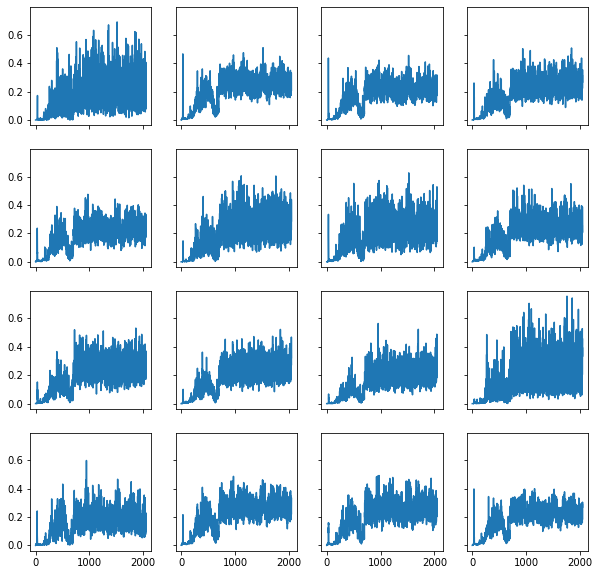

In [ ]:
# Set hyperparameters --------------------------------------------------
iterations = 10000
batch_size = 32
log_interval = iterations//10
gen_output_activation_u='sigmoid' # "sigmoid", "tanh"
gen_layers_u = 1
disc_layers_u = 2
# How many generator training iterations should be performed 
# for 1 training iteration of discriminator
gen_training_freq = 1
disc_training_freq = 1

# gan paaremeters for log
gan_parameters_u = {"label": "u",
                    "gen_output_activation": gen_output_activation_u,
                    "gen_layers": gen_layers_u,
                    "disc_layers": disc_layers_u,
                    "gen_training_freq": gen_training_freq}

# build gan for unbalanced signals
gan_u = buildGAN(sample_size=2048, 
                z_dim=100, 
                gen_layers=gen_layers_u, 
                disc_layers=disc_layers_u, 
                gen_output_activation=gen_output_activation_u, 
                alpha=0.01)

# Train the GAN for the specified number of iterations
# For continuing training comment buildGAN line
gan_u, metrics_u = trainGAN(gan_u, 
                            X_red_u, 
                            freqs, 
                            iter=iterations, 
                            batch_size=batch_size, 
                            log_interval=log_interval, 
                            z_dim=100, 
                            verbose=True, 
                            gen_output_activation=gen_output_activation_u,
                            gen_training_freq=gen_training_freq,
                            disc_training_freq=disc_training_freq)

generator_u = gan_u.layers[0]

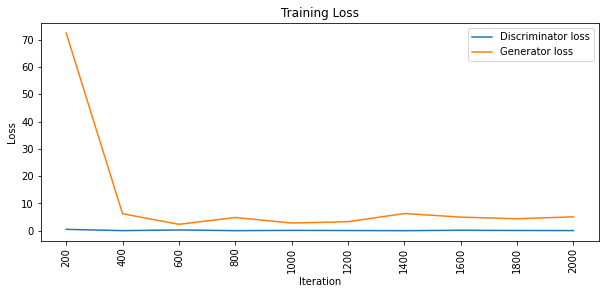

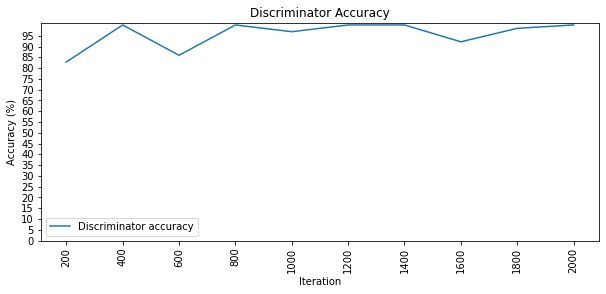

In [ ]:
# example of history and loss of GAN training
iteration_checkpoints = metrics_b['iteration_checkpoints']
losses = np.array(metrics_b["losses"])

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(10, 4))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

accuracies = np.array(metrics_b["accuracies"])

# Plot Discriminator accuracy
plt.figure(figsize=(10, 4))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
generator_b = gan_b.layers[0]
generator_u = gan_u.layers[0]

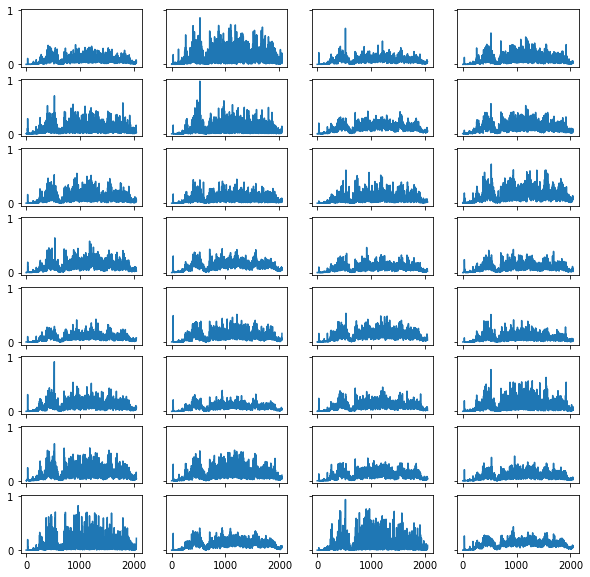

In [ ]:
# example of fake samples produced by GAN
sample_spectrums(generator_b, freqs, image_grid_rows=8, image_grid_columns=4, gen_output_activation='sigmoid')

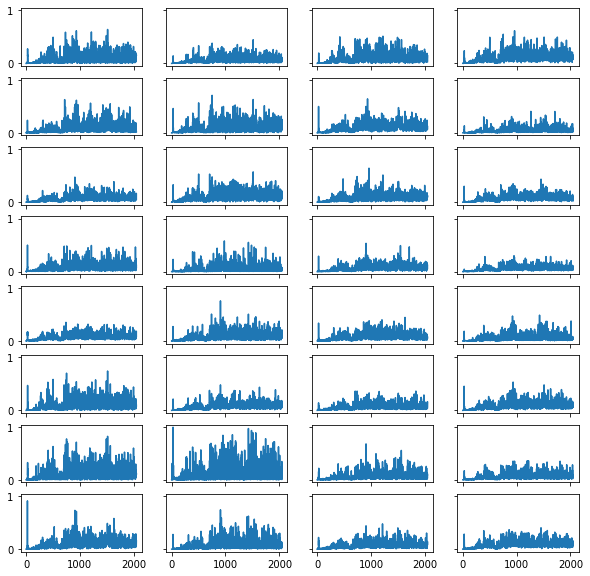

In [ ]:
sample_spectrums(generator_u, freqs, image_grid_rows=8, image_grid_columns=4, gen_output_activation='sigmoid')

In [ ]:
# Save and Load GAN for unbalanced signals
# comment/uncomment the part you need
# --------------
filename_b = "gan_b_2"
filename_u = "gan_u_2"
# # additional comment to saved model
# gan_parameters_b['comment'] = ""
# gan_parameters_u['comment'] = ""

path = "/content/drive/My Drive/data_extension_GANs/GANs/"

# # Save
# # GAN - balanced signal
# gan_b.save(f"{path}{filename_b}")
# with open(f"{path}{filename_b}_params.json", "w") as write_file:
#     json.dump(gan_parameters_b, write_file, indent=4)
# # GAN - unbalanced signal
# gan_u.save(f"{path}{filename_u}")
# with open(f"{path}{filename_u}_params.json", "w") as write_file:
#     json.dump(gan_parameters_u, write_file, indent=4)

# ------------
# Load
# GAN - balanced signal
gan_b = keras.models.load_model(f"{path}{filename_b}", compile=True)
with open(f"{path}{filename_b}_params.json") as read_file:
    gan_parameters_b = json.load(read_file)
# GAN - unbalanced signal
gan_u = keras.models.load_model(f"{path}{filename_u}", compile=True)
with open(f"{path}{filename_u}_params.json") as read_file:
    gan_parameters_u = json.load(read_file)

### GANs evaluation

**Reduced dataset (5%)**

In [ ]:
def evaluateGAN(X, 
                y, 
                GANs, 
                GANs_params, 
                model_params, 
                validation_data,
                test_data,
                nb_of_fakes=3000, 
                iterations=1, 
                z_dim=100,
                epochs=50):
    """ Function evaluates the quality of trained GAN by producing nb_of_fakes of 
    fake samples (half-half each label), augumenting reduced dataset with them and then 
    training the main model on this extended training dataset. The test set accuracy of the 
    trained classifier is the GANs quality measure
    ---
    args:
        X                   reduced dataset samples 
        y                   reduced dataset targets
        GANs                list of 2 GANs, 1st producing balanced signals, 2nd imbalanced
        GANs_params         list of 2 GAN's parameter dictionaries
        model_params        dict with best model paraemeters from randomised search 
        validation_data:    validation dataset, in format [X_val, y_val]
        test_data           test dataset, in format [X_test, y_test]
        nb_of_fakes         default=3000, number of fake samples to be produced
        iterations          default=1, number of evaluation iterations    
        z_dim               default=100, noise vector size
        epochs              default=50
    ----
    returns:
        accuracy:           accuracy of the model on the test set (for more than 1 terations - mean accuracy)
    """
    # augument dataset if needed, if 0 just check performence of the model on reduced dataset
    if nb_of_fakes > 0:
        # extract generators from GANs
        gen_b = GANs[0].layers[0]
        gen_u = GANs[1].layers[0]

        # # augument dataset
        # balanced samples
        z = np.random.normal(0, 1, (nb_of_fakes//2, z_dim))
        X_fake_b = gen_b.predict(z, verbose=0)
        # rescale if tanh on output
        if GANs_params[0]['gen_output_activation'] == 'tanh':
            X_fake_b = (X_fake_b + 1)/2

        # unbalanced samples
        z = np.random.normal(0, 1, (nb_of_fakes//2, z_dim))
        X_fake_u = gen_u.predict(z, verbose=0)
        # rescale if tanh on output
        if GANs_params[1]['gen_output_activation'] == 'tanh':
            X_fake_u = (X_fake_u + 1)/2

        # merge with real dataset and shuffle
        X = np.vstack([X, X_fake_b, X_fake_u])
        y = np.concatenate([y, np.zeros(nb_of_fakes//2), np.ones(nb_of_fakes//2)])

        X, y = shuffle(X, y)

    # evaluate models
    accuracies = []

    for i in range(iterations):
        clf = buildModel(input_shape=X.shape[1], 
                             output_shape=1, 
                             neurons=model_params["model__neurons"], 
                             activation=model_params["model__activation"], 
                             dropouts=model_params["model__dropouts"], 
                             optimizer=model_params["optimizer"])

        history_aug = clf.fit(X, 
                            y, 
                            batch_size=model_params["batch_size"], 
                            validation_data=validation_data, 
                            epochs=epochs, 
                            callbacks=callbacks,
                            verbose=0)
        # reduced dataset
        _, acc = clf.evaluate(X_test, y_test, verbose=0)
        accuracies.append(acc)

    return np.mean(accuracies)


In [ ]:
# prepare result table
result_table = pd.DataFrame(columns=['model_id', 'gen_layers', 'disc_layers', 'gen_output_activation', 'accuracy', 'comment'])

# BASELINE
# Evaluate model on reduced dataset
baseline = evaluateGAN(X=X_red, 
                       y=y_red, 
                       GANs=None, 
                       GANs_params=None, 
                       model_params=best_params, 
                       validation_data=[X_val, y_val], 
                       test_data=[X_test, y_test], 
                       nb_of_fakes=0,   # only reduced dataset
                       iterations=10)

new_row = {'model_id': "baseline",
           'gen_layers': " - ",
           'disc_layers': " - ",
           'gen_output_activation': " - ",
           'accuracy': baseline,
           'comment': "Model trained on reduced dataset without data augmentation"}
result_table = result_table.append(new_row, ignore_index=True)

print(f"Accuracy on reduced dataset: {baseline*100:.2f}")

Accuracy on reduced dataset: 92.06


In [ ]:
nb_of_GANs = 7
path = "/content/drive/My Drive/data_extension_GANs/GANs/"


for i in range(1, nb_of_GANs+1):
    print(f"{i}/{nb_of_GANs}")
    # read models and their parameters
    gan_b = keras.models.load_model(f"{path}gan_b_{i}", compile=True)
    with open(f"{path}gan_b_{i}_params.json") as read_file:
        gan_parameters_b = json.load(read_file)
    # GAN - unbalanced signal
    gan_u = keras.models.load_model(f"{path}gan_u_{i}", compile=True)
    with open(f"{path}gan_u_{i}_params.json") as read_file:
        gan_parameters_u = json.load(read_file)

    # evaluate model
    acc = evaluateGAN(X=X_red, 
                       y=y_red, 
                       GANs=[gan_b, gan_u], 
                       GANs_params=[gan_parameters_b, gan_parameters_u], 
                       model_params=best_params, 
                       validation_data=[X_val, y_val], 
                       test_data=[X_test, y_test], 
                       nb_of_fakes=3000,   
                       iterations=10)
    
    new_row = {'model_id': i,
               'gen_layers': gan_parameters_b['gen_layers'],
               'disc_layers': gan_parameters_b['disc_layers'],
               'gen_output_activation': gan_parameters_b["gen_output_activation"],
               'accuracy': acc,
               'comment': gan_parameters_b['comment']}
    result_table = result_table.append(new_row, ignore_index=True)


result_table

1/7
2/7
3/7
4/7
5/7
6/7
7/7


,model_id,gen_layers,disc_layers,gen_output_activation,accuracy,comment
0,baseline,-,-,-,0.920644,Model trained on reduced dataset without data ...
1,1,1,2,sigmoid,0.947840,trained for 40 000 iterations
2,2,2,2,sigmoid,0.940227,"trained for 40 000 iterations, mode collapses ..."
3,3,1,2,sigmoid,0.961190,After 10000 training iterations another 20000...
4,4,2,2,sigmoid,0.945609,30000 training iterations with 2 training ite...
5,5,1,2,tanh,0.890085,"40000 iterations, mode collapse observed"
6,6,1,2,tanh,0.955559,30000 training iterations with 3 training iter...
7,7,1,2,tanh,0.909171,20000 training iterations with 5 training iter...


In [ ]:
# Save the results table on google drive
result_table.to_excel(f"{path}result_table.xlsx")